<a href="https://colab.research.google.com/github/VIPlearner/csv-files/blob/main/XGBboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [4]:
df=pd.read_csv("https://raw.githubusercontent.com/VIPlearner/csv-files/main/Train.csv", index_col="VehicleID")
#dropping irrelevant features
#df.drop(['Colour'], axis = 1, inplace = True)
#df.drop(['Maker'], axis = 1, inplace = True)
#df.drop(['Model'], axis = 1, inplace = True)
# df.drop(['Location'], axis = 1, inplace = True)
df['Year'] = df['Year'].str.replace(',', '').astype(float)
df['Distance'] = df['Distance'].str.replace(',', '').astype(float)
df['Location'] = df.Location.astype('category')
df['Type'] = df.Type.astype('category')
df['Maker'] = df.Maker.astype('category')
df['Model'] = df.Model.astype('category')
df['Colour'] = df.Colour.astype('category')
df = df[~(np.isnan(df["Amount (Million Naira)"]))]
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Amount (Million Naira)'], axis = 1), df['Amount (Million Naira)'],
                                                    test_size = 0.3,
                                                   random_state = 42)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7188 entries, VHL12546 to VHL15246
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Location                7188 non-null   category
 1   Maker                   7188 non-null   category
 2   Model                   7188 non-null   category
 3   Year                    7167 non-null   float64 
 4   Colour                  7188 non-null   category
 5   Amount (Million Naira)  7188 non-null   float64 
 6   Type                    6992 non-null   category
 7   Distance                4836 non-null   float64 
dtypes: category(5), float64(3)
memory usage: 570.1+ KB


Year                         AxesSubplot(0.125,0.657941;0.227941x0.222059)
Amount (Million Naira)    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
Distance                  AxesSubplot(0.672059,0.657941;0.227941x0.222059)
dtype: object

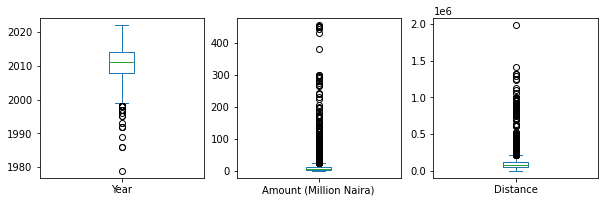

In [5]:
df.plot(kind="box", subplots=True, layout=(3,3), figsize=(10,10))

In [116]:
#numeric_features = ["Year", "Type"]
year_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("scaler", MinMaxScaler())]
)

distance_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
)

type_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
categorical_features = ["Location", "Model", 'Maker', 'Colour']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("year", year_transformer, ["Year"]),
        ("distance", year_transformer, ["Distance"]),
        ("cat", categorical_transformer, categorical_features),
        ("type_cat", type_transformer, ["Type"]),  
    ]
)



In [117]:
pipeline = Pipeline(
  steps=[("preprocessor", preprocessor), ("estimator", XGBRegressor())]
)



In [118]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'estimator', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__year', 'preprocessor__distance', 'preprocessor__cat', 'preprocessor__type_cat', 'preprocessor__year__memory', 'preprocessor__year__steps', 'preprocessor__year__verbose', 'preprocessor__year__imputer', 'preprocessor__year__scaler', 'preprocessor__year__imputer__add_indicator', 'preprocessor__year__imputer__copy', 'preprocessor__year__imputer__fill_value', 'preprocessor__year__imputer__missing_values', 'preprocessor__year__imputer__strategy', 'preprocessor__year__imputer__verbose', 'preprocessor__year__scaler__clip', 'preprocessor__year__scaler__copy', 'preprocessor__year__scaler__feature_range', 'preprocessor__distance__memory', 'preprocessor__distance__steps', 'preprocessor__distance__v

In [119]:
parameters = {#'estimator__alpha': [1],
              #'estimator':[DecisionTreeRegressor()],
              'estimator__max_depth': [3],
              'estimator__learning_rate': [0.1],
              'estimator__n_estimators': [3000],
              'estimator__colsample_bytree': [1], 
}

In [120]:
grid = GridSearchCV(pipeline, parameters, cv=2)

grid.fit(X_train, y_train)  
 

[13:01:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('year',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Year']),
                                                                        ('distance',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),


In [121]:
grid.best_params_

{'estimator__colsample_bytree': 1,
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 3,
 'estimator__n_estimators': 3000}

In [122]:
print("model score: %.3f" % grid.score(X_test, y_test))

model score: 0.762


In [123]:
y_pred = grid.predict(X_test)
errors = mean_squared_error(y_test, y_pred, squared = False) 
print(errors)

10.671337000561033


In [87]:
test_df=pd.read_csv("https://raw.githubusercontent.com/VIPlearner/csv-files/main/Test.csv")
test_df.head()
#dropping irrelevant features
# test_df.drop(['Colour'], axis = 1, inplace = True)
# test_df.drop(['Maker'], axis = 1, inplace = True)
# test_df.drop(['Model'], axis = 1, inplace = True)
# test_df.drop(['Location'], axis = 1, inplace = True)
test_df['Year'] = test_df['Year'].str.replace(',', '').astype(float)
#test_df['Distance'] = test_df['Distance'].str.replace(',', '').astype(float)
test_df['Location'] = test_df.Location.astype('category')
test_df['Type'] = test_df.Type.astype('category')
test_df['Maker'] = test_df.Maker.astype('category')
test_df['Model'] = test_df.Model.astype('category')
test_df['Colour'] = test_df.Colour.astype('category')

In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   VehicleID  2061 non-null   object  
 1   Location   2061 non-null   category
 2   Maker      2061 non-null   category
 3   Model      2061 non-null   category
 4   Year       2059 non-null   float64 
 5   Colour     2061 non-null   category
 6   Type       2007 non-null   category
 7   Distance   1385 non-null   float64 
dtypes: category(5), float64(2), object(1)
memory usage: 83.6+ KB


In [89]:
test_y_pred = grid.predict(test_df)

In [90]:
test_pred_df = pd.DataFrame({'VehicleID' : test_df['VehicleID'], 'Amount (Million Naira)': test_y_pred})
test_pred_df.head

<bound method NDFrame.head of      VehicleID  Amount (Million Naira)
0     VHL18518                6.118701
1     VHL17149                6.601268
2     VHL10927                4.355775
3     VHL12909                4.913404
4     VHL12348                9.224973
...        ...                     ...
2056  VHL17903               22.420389
2057  VHL14018                6.245449
2058  VHL17473                7.437510
2059  VHL11480                9.115562
2060  VHL13881                3.605883

[2061 rows x 2 columns]>

In [91]:
test_pred_df.to_csv('fifteenthtry.csv', encoding='utf-8', index=False)

In [92]:
from google.colab import files
files.download("fifteenthtry.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
help(XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain', **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of trees to fit.
 |  verbosity : int
 |      The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |  silent : boolean
 |      Whether to print messages while running boostin